# HIV-1 Protease Cleavage Prediction

This notebook was developed by **I Made Akira Ivandio Agusta (15406525)**, Coventry University.

This notebook implements **Gaussian Process Classification (GPC)** with **Bayesian Optimisation** to enhance HIV-1 protease cleavage prediction. In addition, the developed model is compared to Linear Support Vector Machine (LSVM) as a baseline due to its established efficiency in earlier work.

The datasets used in this study are from human proteins **(Schilling and Impens)** and synthetic variations **(746 and 1625)**.

## Data Loading

This section focuses on **integrating multiple HIV-1 protease cleavage datasets** from human proteins and synthetic sources. A visualisation of class distribution confirms the dataset's imbalanced nature, showing significantly more non-cleaved sequences than cleaved ones.

In [ ]:
# Install libraries
!pip install bayesian-optimization

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from bayes_opt import BayesianOptimization
from scipy.sparse import csr_matrix
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, RBF
from sklearn.metrics import accuracy_score, auc, f1_score, make_scorer, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.svm import LinearSVC

In [ ]:
# Function to load a single dataset from a text file
def load_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            sequence, label = line.strip().split(',')
            data.append((sequence, int(label)))
    return data

# Function to merge datasets and remove duplicates
def merge_datasets(file_paths):
    merged_data = {}

    for file_path in file_paths:
        data = load_dataset(file_path)
        for sequence, label in data:
            if sequence not in merged_data:
                merged_data[sequence] = label

    # Convert the merged data into a DataFrame
    merged_df = pd.DataFrame(list(merged_data.items()), columns=['Sequence', 'Label'])
    return merged_df

# Function to save the merged dataset to a CSV file
def save_merged_dataset(merged_df, output_file):
    merged_df.to_csv(output_file, index=False)

In [ ]:
# Set up plotting
%matplotlib inline
plt.style.use('ggplot')

# List of dataset file paths
file_paths = ['dataset/schillingData.txt', 'dataset/impensData.txt', 'dataset/746Data.txt', 'dataset/1625Data.txt']

# Merge the datasets and remove duplicates
merged_df = merge_datasets(file_paths)

# Save the merged dataset to a CSV file
dataset_path = 'dataset/merged_dataset.csv'
save_merged_dataset(merged_df, dataset_path)

# Print the number of sequences in the merged dataset
print(f"Merged dataset saved to {dataset_path} with {len(merged_df)} sequences.")

Merged dataset saved to dataset/merged_dataset.csv with 5840 sequences.



Class Distribution:
Label
-1    4844
 1     996
Name: count, dtype: int64


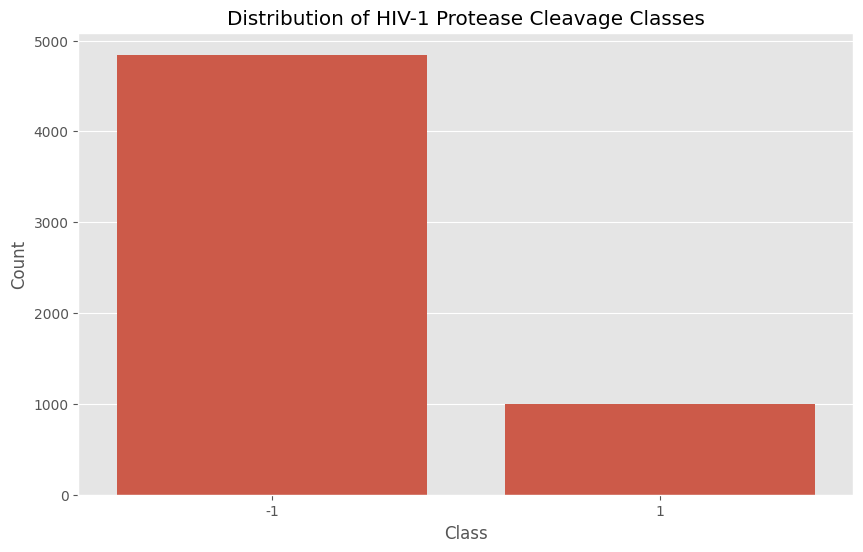

In [ ]:
# Check class distribution
print("\nClass Distribution:")
class_dist = merged_df['Label'].value_counts()
print(class_dist)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Distribution of HIV-1 Protease Cleavage Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

This section transforms the raw amino acid sequences into machine learning-compatible features using **one-hot encoding (orthogonal encoding)**. Each of the 8 amino acid positions in a sequence is expanded into 20 binary features (one for each possible amino acid), creating a comprehensive **160-dimensional feature space**.

In [ ]:
# Function to one-hot encode peptide sequences
def one_hot_encode_sequences(sequences):
    # Define the 20 amino acids
    amino_acids = 'ARNDCQEGHILKMFPSTWYV'

    # Create a mapping from amino acids to indices
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize an empty array to store the one-hot encoded sequences
    encoded_sequences = np.zeros((len(sequences), 8, 20), dtype=int)

    # Encode each sequence
    for i, sequence in enumerate(sequences):
        for j, aa in enumerate(sequence):
            if aa in aa_to_index:
                encoded_sequences[i, j, aa_to_index[aa]] = 1
            else:
                # Handle unknown amino acids by assigning zeros
                print(f"Warning: Unknown amino acid '{aa}' in sequence: {sequence}")

    # Reshape the encoded sequences to 2D (n_samples, 160)
    encoded_sequences = encoded_sequences.reshape(len(sequences), -1)

    return encoded_sequences

# Function to preprocess the merged dataset
def preprocess_dataset(file_path):
    # Load the merged dataset from the CSV file
    df = pd.read_csv(file_path)

    # Extract sequences and labels
    sequences = df['Sequence'].tolist()
    labels = df['Label'].values

    # Convert labels from [-1, 1] to [0, 1]
    labels = np.where(labels == -1, 0, labels)

    # One-hot encode the sequences
    X = one_hot_encode_sequences(sequences)

    return X, labels

# Function to preprocess individual datasets
def load_and_preprocess_dataset(file_path):
    # Load the dataset from the text file
    data = load_dataset(file_path)
    sequences = [item[0] for item in data]
    labels = np.array([item[1] for item in data])

    # Convert labels from [-1, 1] to [0, 1]
    labels = np.where(labels == -1, 0, labels)

    # One-hot encode the sequences
    X = one_hot_encode_sequences(sequences)

    return X, labels

In [ ]:
# Preprocess the merged dataset
X, y = preprocess_dataset(dataset_path)

# Use data subset for training
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=0.5, stratify=y, random_state=42)
print(f"Using subset of data for training: {X_subset.shape[0]} samples")

Using subset of data for training: 2920 samples


## Model Training and Cross-Validation

This section implements and evaluates three classification methods:

> **GPC with a Radial Basis Function kernel, GPC with a linear kernel, and LSVM.**

Performance evaluation employs 3-stratified cross-validation with AUC-ROC and F1 score metrics, accompanied by ROC curve visualisations for each classifier. Results demonstrate that **GPC-RBF is the optimal model**.

In [ ]:
# Define a function to evaluate different classifiers
def evaluate_classifiers(X, y):
    # Define classifiers
    classifiers = {
        'LSVM': LinearSVC(random_state=42, max_iter=2000, class_weight='balanced'),
        'GPC-RBF': GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=42, n_restarts_optimizer=0, max_iter_predict=100),
        'GPC-Linear': GaussianProcessClassifier(kernel=DotProduct(), random_state=42, n_restarts_optimizer=0, max_iter_predict=100)
    }

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Dictionary to store results and ROC scores
    results = {}
    roc_data = {}

    # Evaluate each classifier
    for name, classifier in classifiers.items():
        print(f"Evaluating {name}...")
        start_time = time.time()

        # Perform cross-validation for F1 score
        f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)

        # Evaluate AUC-ROC score
        if name == 'LSVM':
            y_scores = cross_val_predict(classifier, X, y, cv=cv, method='decision_function', n_jobs=-1)
            auc_roc = roc_auc_score(y, y_scores)
            roc_data[name] = {'y_true': y, 'y_scores': y_scores}

        else:
            y_prob = cross_val_predict(classifier, X, y, cv=cv, method='predict_proba', n_jobs=-1)
            y_scores = y_prob[:, 1]
            auc_roc = roc_auc_score(y, y_scores)
            roc_data[name] = {'y_true': y, 'y_scores': y_scores}

        # Store results
        results[name] = {
            'mean_f1': np.mean(f1_scores),
            'std_f1': np.std(f1_scores),
            'auc_roc': auc_roc,
            'time': time.time() - start_time
        }

        print(f"  Mean F1: {results[name]['mean_f1']:.4f} ± {results[name]['std_f1']:.4f}")
        print(f"  AUC-ROC: {results[name]['auc_roc']:.4f}")
        print(f"  Time: {results[name]['time']:.2f} seconds")

    # Plot ROC curves for all classifiers
    for name, data in roc_data.items():
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(data['y_true'], data['y_scores'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return results

Evaluating LSVM...
  Mean F1: 0.7468 ± 0.0194
  AUC-ROC: 0.9562
  Time: 4.83 seconds
Evaluating GPC-RBF...
  Mean F1: 0.7810 ± 0.0281
  AUC-ROC: 0.9632
  Time: 937.18 seconds
Evaluating GPC-Linear...
  Mean F1: 0.7763 ± 0.0265
  AUC-ROC: 0.9630
  Time: 241.10 seconds


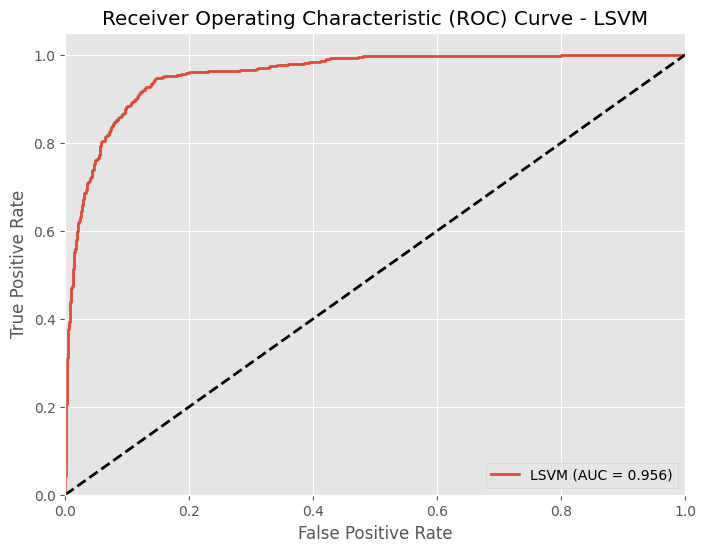

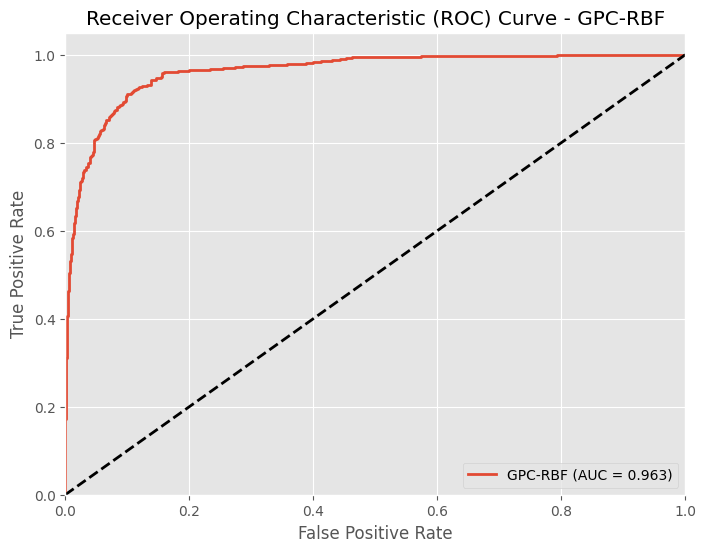

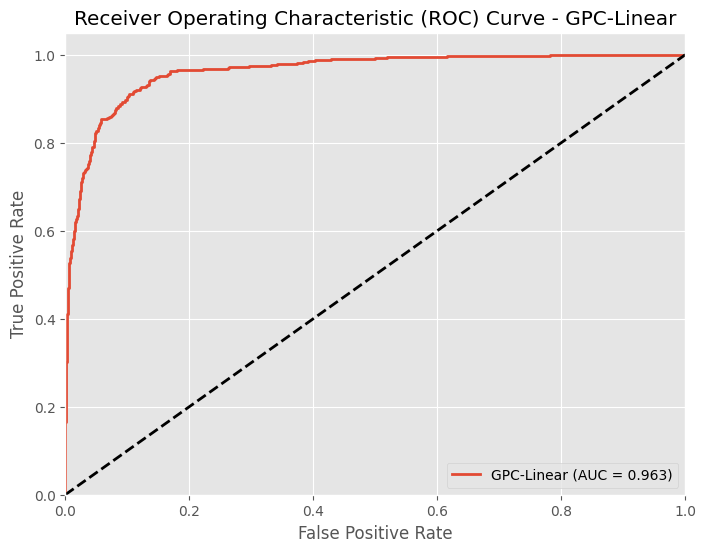

In [ ]:
# Evaluate classifiers on the subset
results = evaluate_classifiers(X_subset, y_subset)

In [ ]:
# Print the best classifier by AUC-ROC
best_classifier_auc = max(results, key=lambda x: results[x]['auc_roc'])
print(f"Best classifier by AUC-ROC: {best_classifier_auc} with AUC-ROC: {results[best_classifier_auc]['auc_roc']:.4f}")

# Print the best classifier by F1 score
best_classifier_f1 = max(results, key=lambda x: results[x]['mean_f1'])
print(f"Best classifier by F1 Score: {best_classifier_f1} with F1: {results[best_classifier_f1]['mean_f1']:.4f}")

Best classifier by AUC-ROC: GPC-RBF with AUC-ROC: 0.9632
Best classifier by F1 Score: GPC-RBF with F1: 0.7810


## Bayesian Optimisation

This section applies Bayesian Optimisation on the following hyperparameters:

*   **GPC-RBF:** length scale and constant value.
*   **GPC-Linear:** sigma.
*   **LSVM:** regulation parameter (C).

In this case, GPC-RBF is optimised since it is the best-performing model.

In [ ]:
# For LSVM
if best_classifier_auc == 'LSVM' or best_classifier_f1 == 'LSVM':
    def evaluate_lsvm(C):
        lsvm = LinearSVC(C=C, random_state=42, max_iter=2000, class_weight='balanced')
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        y_scores = cross_val_predict(lsvm, X_subset, y_subset, cv=cv, method='decision_function', n_jobs=-1)
        return roc_auc_score(y_subset, y_scores)

    # Define the search space
    pbounds = {
        'C': (0.01, 20.0),
    }

    # Initialize and perform Bayesian Optimization
    optimizer = BayesianOptimization(f=evaluate_lsvm, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=4, n_iter=10)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {optimizer.max['params']}")
    print(f"Best AUC-ROC score: {optimizer.max['target']:.4f}")

    # Compare with baseline
    baseline_auc = results['LSVM']['auc_roc']
    improvement = ((optimizer.max['target'] - baseline_auc) / baseline_auc) * 100
    print(f"AUC-ROC without optimization: {baseline_auc:.4f}")
    print(f"AUC-ROC with optimization: {optimizer.max['target']:.4f}")
    print(f"Improvement: {improvement:.2f}%")

    # Train the best model
    best_params = optimizer.max['params']
    best_model = LinearSVC(C=best_params['C'], random_state=42, max_iter=2000, class_weight='balanced')

# For GPC-RBF
elif best_classifier_auc == 'GPC-RBF' or best_classifier_f1 == 'GPC-RBF':
    def evaluate_gpc_rbf(length_scale, constant_value):
        kernel = ConstantKernel(constant_value) * RBF(length_scale)
        gpc = GaussianProcessClassifier(kernel=kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(gpc, X_subset, y_subset, cv=cv, scoring='roc_auc', n_jobs=-1)
        return np.mean(scores)

    # Define the search space
    pbounds = {
        'length_scale': (0.05, 20.0),
        'constant_value': (0.05, 20.0),
    }

    # Initialize and perform Bayesian Optimization
    optimizer = BayesianOptimization(f=evaluate_gpc_rbf, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=4, n_iter=10)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {optimizer.max['params']}")
    print(f"Best AUC-ROC score: {optimizer.max['target']:.4f}")

    # Compare with baseline
    baseline_auc = results['GPC-RBF']['auc_roc']
    improvement = ((optimizer.max['target'] - baseline_auc) / baseline_auc) * 100
    print(f"AUC-ROC without optimization: {baseline_auc:.4f}")
    print(f"AUC-ROC with optimization: {optimizer.max['target']:.4f}")
    print(f"Improvement: {improvement:.2f}%")

    # Train the best model
    best_params = optimizer.max['params']
    best_kernel = ConstantKernel(best_params['constant_value']) * RBF(best_params['length_scale'])
    best_model = GaussianProcessClassifier(kernel=best_kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)

# For GPC-Linear
elif best_classifier_auc == 'GPC-Linear' or best_classifier_f1 == 'GPC-Linear':
    def evaluate_gpc_linear(sigma_0):
        kernel = DotProduct(sigma_0)
        gpc = GaussianProcessClassifier(kernel=kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(gpc, X_subset, y_subset, cv=cv, scoring='roc_auc', n_jobs=-1)
        return np.mean(scores)

    # Define the search space
    pbounds = {
        'sigma_0': (0.01, 20.0),
    }

    # Initialize and perform Bayesian Optimization
    optimizer = BayesianOptimization(f=evaluate_gpc_linear, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=4, n_iter=10)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {optimizer.max['params']}")
    print(f"Best AUC-ROC score: {optimizer.max['target']:.4f}")

    # Compare with baseline
    baseline_auc = results['GPC-Linear']['auc_roc']
    improvement = ((optimizer.max['target'] - baseline_auc) / baseline_auc) * 100
    print(f"AUC-ROC without optimization: {baseline_auc:.4f}")
    print(f"AUC-ROC with optimization: {optimizer.max['target']:.4f}")
    print(f"Improvement: {improvement:.2f}%")

    # Train the best model
    best_params = optimizer.max['params']
    best_kernel = DotProduct(sigma_0=best_params['sigma_0'])
    best_model = GaussianProcessClassifier(kernel=best_kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)

|   iter    |  target   | consta... | length... |
-------------------------------------------------
| 1         | 0.9632    | 7.522     | 19.02     |
| 2         | 0.9632    | 14.65     | 11.99     |
| 3         | 0.9632    | 3.163     | 3.162     |
| 4         | 0.9632    | 1.209     | 17.33     |
| 5         | 0.9632    | 1.296     | 17.43     |
| 6         | 0.9632    | 0.09495   | 19.94     |
| 7         | 0.9632    | 2.711     | 16.19     |
| 8         | 0.9632    | 0.5266    | 17.91     |
| 9         | 0.9632    | 1.715     | 17.11     |
| 10        | 0.9632    | 1.092     | 17.52     |
| 11        | 0.9632    | 8.864     | 16.5      |
| 12        | 0.9632    | 1.292     | 17.3      |
| 13        | 0.9632    | 7.933     | 9.773     |
| 14        | 0.9632    | 13.82     | 2.492     |
Best hyperparameters: {'constant_value': np.float64(1.2087680627555792), 'length_scale': np.float64(17.330214108209958)}
Best AUC-ROC score: 0.9632
AUC-ROC without optimization: 0.9632
AUC-ROC with op

## Cross-Dataset Evaluation

This section rigorously assesses model generalisability by conducting comprehensive **cross-dataset testing among all four datasets**. Each dataset serves alternately as training and testing data, creating a comprehensive evaluation matrix visualised via heatmaps for AUC-ROC and F1 scores.

In [ ]:
# Load and preprocess individual datasets
X_746, y_746 = load_and_preprocess_dataset('dataset/746Data.txt')
X_1625, y_1625 = load_and_preprocess_dataset('dataset/1625Data.txt')
X_schilling, y_schilling = load_and_preprocess_dataset('dataset/schillingData.txt')
X_impens, y_impens = load_and_preprocess_dataset('dataset/impensData.txt')

# Define the datasets
datasets = {
    '746': (X_746, y_746),
    '1625': (X_1625, y_1625),
    'Schilling': (X_schilling, y_schilling),
    'Impens': (X_impens, y_impens)
}

# Initialize a matrix to store the results for AUC-ROC and F1 scores
results_auc = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())
results_f1 = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())

In [ ]:
# Function to train and test model using AUC-ROC and F1 score
def train_and_test_model(X_train, y_train, X_test, y_test, model_type, best_params):
    if model_type == 'LSVM':
        model = LinearSVC(C=best_params['C'], random_state=42, max_iter=2000, class_weight='balanced')
    elif model_type == 'GPC-RBF':
        kernel = ConstantKernel(best_params['constant_value']) * RBF(best_params['length_scale'])
        model = GaussianProcessClassifier(kernel=kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)
    elif model_type == 'GPC-Linear':
        kernel = DotProduct(sigma_0=best_params['sigma_0'])
        model = GaussianProcessClassifier(kernel=kernel, random_state=42, n_restarts_optimizer=0, max_iter_predict=100)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    if model_type == 'LSVM':
        y_decision = model.decision_function(X_test)
        y_pred = model.predict(X_test)
        auc_roc = roc_auc_score(y_test, y_decision)
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        auc_roc = roc_auc_score(y_test, y_prob)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    return auc_roc, f1

In [ ]:
# Perform cross-dataset training and testing
for train_name, (X_train, y_train) in datasets.items():
    for test_name, (X_test, y_test) in datasets.items():
        if train_name == test_name:
            results_auc.loc[train_name, test_name] = '-'
            results_f1.loc[train_name, test_name] = '-'
        else:
            print(f"Training on {train_name}, testing on {test_name}...")
            auc_roc, f1 = train_and_test_model(X_train, y_train, X_test, y_test, best_classifier_auc, optimizer.max['params'])
            results_auc.loc[train_name, test_name] = f"{auc_roc:.3f}"
            results_f1.loc[train_name, test_name] = f"{f1:.3f}"

Training on 746, testing on 1625...
Training on 746, testing on Schilling...
Training on 746, testing on Impens...
Training on 1625, testing on 746...
Training on 1625, testing on Schilling...
Training on 1625, testing on Impens...
Training on Schilling, testing on 746...
Training on Schilling, testing on 1625...
Training on Schilling, testing on Impens...
Training on Impens, testing on 746...
Training on Impens, testing on 1625...
Training on Impens, testing on Schilling...


In [ ]:
# Print the cross-dataset results
print("\nCross-dataset results (AUC-ROC scores):")
print(results_auc)

print("\nCross-dataset results (F1 scores):")
print(results_f1)


Cross-dataset results (AUC-ROC scores):
             746   1625 Schilling Impens
746            -  0.988     0.884  0.843
1625       0.987      -     0.874  0.825
Schilling  0.945  0.937         -  0.922
Impens     0.913  0.898     0.927      -

Cross-dataset results (F1 scores):
             746   1625 Schilling Impens
746            -  0.872     0.562  0.543
1625       0.975      -     0.444  0.474
Schilling  0.690  0.649         -  0.656
Impens     0.779  0.659     0.610      -


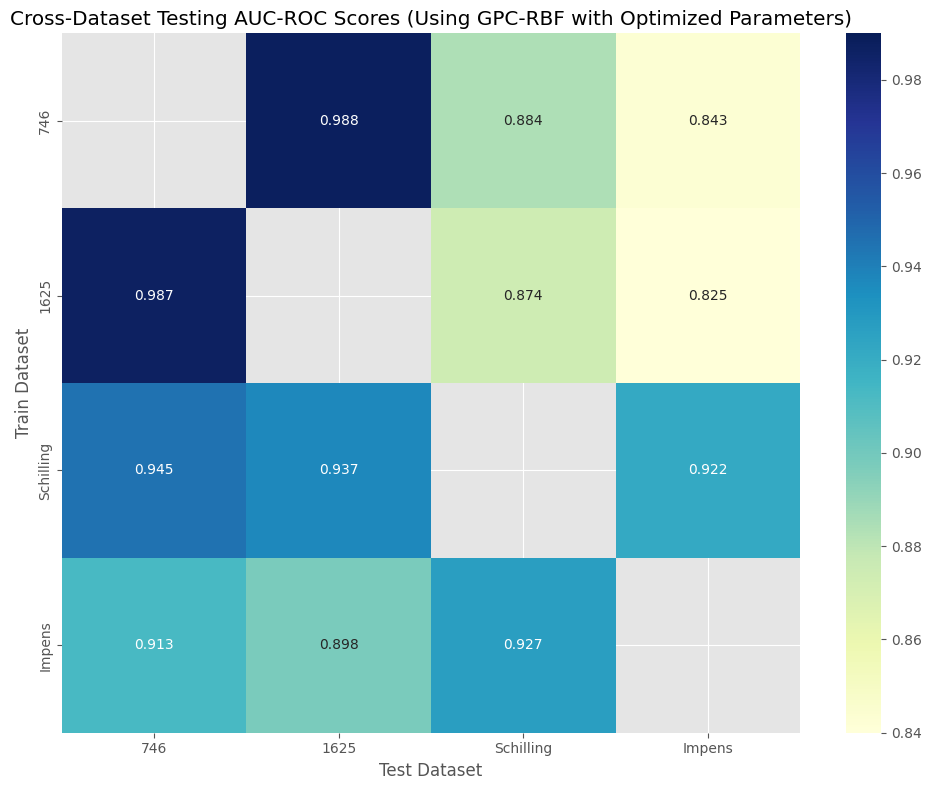

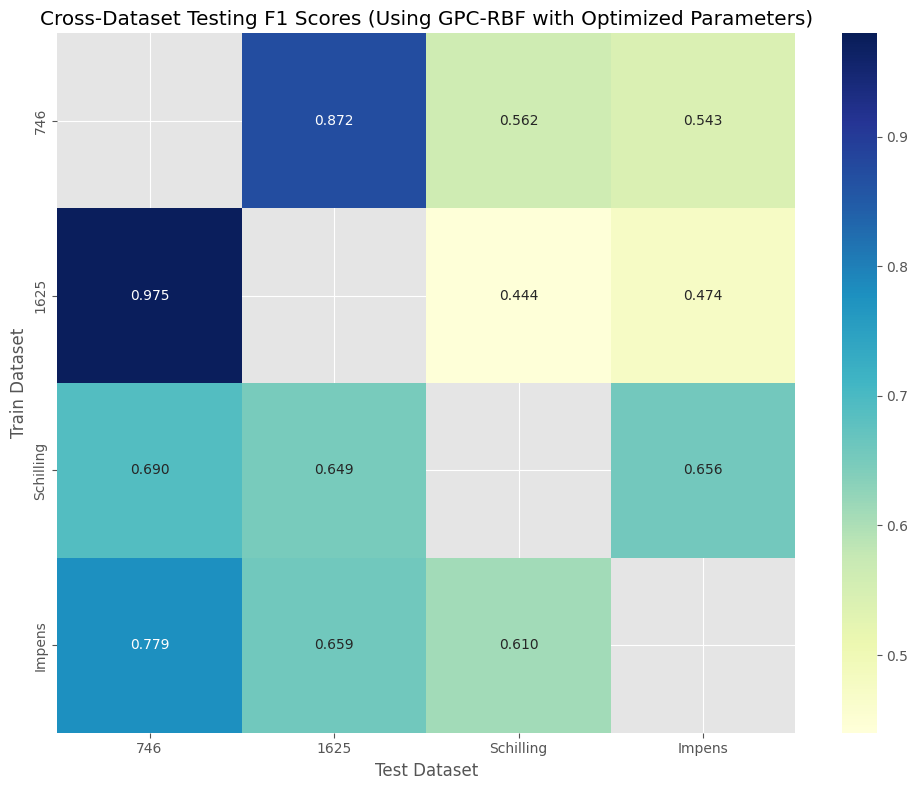

In [ ]:
# Visualize cross-dataset results as heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(results_auc.replace('-', np.nan).astype(float), annot=True, cmap='YlGnBu', fmt='.3f')
plt.title(f'Cross-Dataset Testing AUC-ROC Scores (Using {best_classifier_auc} with Optimized Parameters)')
plt.xlabel('Test Dataset')
plt.ylabel('Train Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(results_f1.replace('-', np.nan).astype(float), annot=True, cmap='YlGnBu', fmt='.3f')
plt.title(f'Cross-Dataset Testing F1 Scores (Using {best_classifier_auc} with Optimized Parameters)')
plt.xlabel('Test Dataset')
plt.ylabel('Train Dataset')
plt.tight_layout()
plt.show()